# Visual Transformers Training

## Including the needed libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from vit_keras import vit
from vit_keras import visualize
from scipy.special import softmax

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

/home/ld/anaconda3/envs/dl/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.7.0-dev20210924). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


TensorFlow Version 2.7.0-dev20210924


## Setting the parameters

In [2]:
IMAGE_SIZE = 160
BATCH_SIZE = 16
EPOCHS = 100

train_dir = '../dataset/data/classified'
val_dir = '../dataset/data/validation'
test_dir = '../dataset/data/test'

classes = {0 : "Baby",
           1 : "Not Baby"}

## Defining Data Augmentation Function

In [3]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

## Defining Data Generators

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          preprocessing_function = data_augment)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True)


val_test_datagen.apply_transform

train_ds = datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed = 1,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

val_ds = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

test_ds = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        class_mode='binary')

# test_ds = tf.keras.utils.image_dataset_from_directory(
#         test_dir,
#         image_size=(IMAGE_SIZE, IMAGE_SIZE),
#         batch_size=BATCH_SIZE)

Found 135 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


2021-09-26 20:30:05.669876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 20:30:05.796720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 20:30:05.797694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 20:30:05.803717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 20:30:05.804636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

(160, 160, 3)


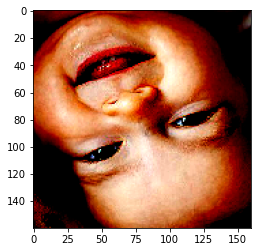

In [5]:
x = train_ds.next()
image = x[0][0]
print(image.shape)
plt.imshow(image)

In [6]:
cat_img = plt.imread('../dataset/data/classified/baby/1.jpeg')

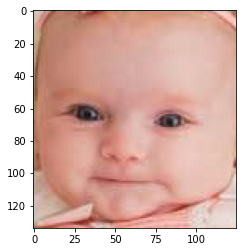

In [7]:
plt.imshow(cat_img)

## Loading the Visual Transformers Model

In [9]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

## Visualizing the Attention maps

In [10]:
def vizualize():
    x = train_ds.next()
    image = x[0][0]
    print(image.shape)

    attention_map = visualize.attention_map(model = vit_model, image = image)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(ncols = 2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(image)
    _ = ax2.imshow(((255 - attention_map)))

(160, 160, 3)


2021-09-26 20:30:16.228271: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


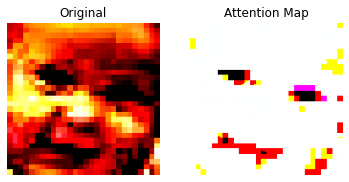

In [11]:
vizualize()

## Creating the model

In [12]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, 'sigmoid')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87436800  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 16)                12304     
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)          

## Defining Callbacks

In [13]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.binary_crossentropy, 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_ds.n // train_ds.batch_size
# STEP_SIZE_VALID = val_ds.n // val_ds.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 10,
#                                                  verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 30,
                                                 mode = 'max',
#                                                  verbose = 1,
                                                 restore_best_weights = True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
#                                                   verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [checkpointer, reduce_lr, earlystopping] #reduce_lr earlystopping



## Training the Model

In [14]:
model.fit(x = train_ds,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_ds,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model.h5')

Epoch 1/100
8/8 [==============================] - 51s 993ms/step - loss: 0.8529 - accuracy: 0.5882 - val_loss: 0.8411 - val_accuracy: 0.5806 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 2s 286ms/step - loss: 0.8817 - accuracy: 0.5126 - val_loss: 0.7961 - val_accuracy: 0.5806 - lr: 1.0000e-04
Epoch 3/100
8/8 [==============================] - 6s 757ms/step - loss: 0.7621 - accuracy: 0.5714 - val_loss: 0.7198 - val_accuracy: 0.6129 - lr: 1.0000e-04
Epoch 4/100
8/8 [==============================] - 5s 724ms/step - loss: 0.6190 - accuracy: 0.6807 - val_loss: 0.6409 - val_accuracy: 0.6774 - lr: 1.0000e-04
Epoch 5/100
8/8 [==============================] - 2s 298ms/step - loss: 0.5987 - accuracy: 0.6975 - val_loss: 0.5637 - val_accuracy: 0.6774 - lr: 1.0000e-04
Epoch 6/100
8/8 [==============================] - 5s 673ms/step - loss: 0.4339 - accuracy: 0.7983 - val_loss: 0.4981 - val_accuracy: 0.8387 - lr: 1.0000e-04
Epoch 7/100
8/8 [==============================] - 

In [15]:
# test_model = tf.keras.models.load_model("./Models/best_model.h5")

In [16]:
# test_model.evaluate(test_ds)

## Evaluating the model on test set

In [17]:
model.evaluate(test_ds)

2/2 [==============================] - 0s 60ms/step - loss: 0.0748 - accuracy: 1.0000


[0.07482504844665527, 1.0]

In [18]:
res = model.predict(test_ds)

In [19]:
res

array([[8.6563951e-01],
       [4.5157373e-03],
       [9.7280955e-01],
       [7.4629784e-01],
       [4.3100268e-02],
       [9.6793449e-01],
       [9.7961169e-01],
       [6.5307462e-01],
       [9.9198759e-01],
       [1.1128676e-02],
       [3.9635073e-02],
       [3.0873474e-03],
       [1.0577036e-03],
       [9.3340784e-01],
       [9.5893335e-01],
       [8.4038913e-01],
       [8.0943003e-04],
       [5.1420326e-03]], dtype=float32)

In [20]:
res[res >= 0.5] = 1

In [21]:
res[res < 0.5] = 0

In [22]:
res

array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [23]:
# test_ds